# IMPORTS AND INSTALLATIONS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import tqdm.notebook as tq

import warnings
warnings.filterwarnings('ignore')
import networkx as nx
from operator import itemgetter
import operator
import collections
import pickle
import os


# LOADING DATASETS

In [35]:
df = pd.read_csv("/content/drive/MyDrive/ANU/project/dataset/IRN_DATASET.csv")
df = df.dropna()
df.head()

,Train No,Train Name,SEQ,Station Code,Station Name,Arrival time,Departure Time,Distance,Source Station,Source Station Name,Destination Station,Destination Station Name
0,107,SWV-MAO-VLNK,1,SWV,SAWANTWADI R,00:00:00,10:25:00,0,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
1,107,SWV-MAO-VLNK,2,THVM,THIVIM,11:06:00,11:08:00,32,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
2,107,SWV-MAO-VLNK,3,KRMI,KARMALI,11:28:00,11:30:00,49,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
3,107,SWV-MAO-VLNK,4,MAO,MADGOAN JN.,12:10:00,00:00:00,78,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
4,108,VLNK-MAO-SWV,1,MAO,MADGOAN JN.,00:00:00,20:30:00,0,MAO,MADGOAN JN.,SWV,SAWANTWADI ROAD


In [4]:
df2 = pd.read_csv("/content/drive/MyDrive/ANU/project/dataset/IRN_DATASET2.csv")
df2 = df2.dropna()
df2.head()

,Train No,Train Name,SEQ,Station Code,Station Name,Station Zone,Arrival time,Departure Time,Distance,Source Station,Source Station Name,Source Zone,Destination Station,Destination Station Name,Destination Zone
0,75222,CPR-SEE DEMU,8,AABH,AMBIKA BHAWA,ECR,19:17:00,19:18:00,26,CPR,CHHAPRA JN.,NER,SEE,SONPUR JN.,ECR
1,55008,GKP-PPTA PAS,43,AABH,AMBIKA BHAWA,ECR,09:43:00,09:44:00,253,GKP,GORAKHPUR JN.,NER,PPTA,PATLIPUTRA,ECR
2,55007,PPTA-GKP PAS,8,AABH,AMBIKA BHAWA,ECR,19:11:00,19:12:00,36,PPTA,PATLIPUTRA,ECR,GKP,GORAKHPUR JN.,NER
3,75201,SEE-CPR DEMU,6,AABH,AMBIKA BHAWA,ECR,07:56:00,07:57:00,26,SEE,SONPUR JN.,ECR,CPR,CHHAPRA JN.,NER
4,14554,HIMACHAL EXP,1,AADR,AMB ANDAURA,NR,20:10:00,20:10:00,0,AADR,AMB ANDAURA,NR,DLI,DELHI JN.,NR


##GENERAL ANALYSIS OF DATA

total no. of stations and trains





In [4]:
print('Number of trains:', len(np.unique(df['Train Name'].astype('str'))))
print('Number of stations:', len(np.unique(df['Station Code'].astype('str'))))

Number of trains: 7585
Number of stations: 8151


no. of zones

In [8]:
print('Number of Zones:', len(np.unique(df2['Source Zone'].astype('str'))))

Number of Zones: 18


what zone is biggest

In [9]:
import pandas as pd

same_zone_df = df2[df2['Source Zone'] == df2['Destination Zone']]

# Count the occurrences of each zone
zone_counts = same_zone_df['Source Zone'].value_counts()

# Find the zone with the maximum count
max_zone = zone_counts.idxmax()
max_count = zone_counts.max()

print(f"The zone with the most records where the source and destination are the same is '{max_zone}' with {max_count} occurrences.")


The zone with the most records where the source and destination are the same is 'ER' with 26169 occurrences.


In [10]:
import pandas as pd

same_zone_df = df2[df2['Source Zone'] == df2['Destination Zone']]

# Count the occurrences of each zone and print them in descending order
zone_counts = same_zone_df['Source Zone'].value_counts()

print("Zones sorted by the number of records where the source equals the destination:")
print(zone_counts)


Zones sorted by the number of records where the source equals the destination:
Source Zone
ER      26169
SR      19017
CR      14893
NR      12846
SCR      8805
WR       6054
ECR      3394
SWR      3075
NER      3016
NWR      2372
SER      1859
NFR      1500
ECoR     1321
SECR     1277
NCR      1265
WCR       803
KR         48
Name: count, dtype: int64


longest/shortest train route etc

In [13]:
distances = df['Distance'].astype(int)
longest_route = distances.idxmax()
shortest_route = distances.idxmin()

print('Longest train route:', distances.max(), 'km. Train =', df.loc[longest_route, 'Train No'], df.loc[longest_route, 'Train Name'], '. Starting station:', df.loc[longest_route, 'Source Station Name'], '. Ending Station:', df.loc[longest_route, 'Destination Station Name'])
print('Shortest train route:', distances.min(), 'km. Train =', df.loc[shortest_route, 'Train No'], df.loc[shortest_route, 'Train Name'], '. Starting station:', df.loc[shortest_route, 'Source Station Name'], '. Ending Station:', df.loc[shortest_route, 'Destination Station Name'])

max_distance = 0
min_distance = distances.max()
min_train = ''
max_train = ''
total_route_distance = 0

for train_name in df['Train Name'].unique():
    train_df = df[df['Train Name'] == train_name]
    train_distances = train_df['Distance'].astype(int)
    station_differences = train_distances.diff().dropna().astype(int)

    current_min = station_differences[station_differences > 0].min()
    current_max = station_differences.max()

    if current_min < min_distance:
        min_distance = current_min
        min_train = train_name
    if current_max > max_distance:
        max_distance = current_max
        max_train = train_name

    total_route_distance += train_distances.iloc[-1]

average_route_distance = total_route_distance / len(df['Train Name'].unique())
average_stop_distance = total_route_distance / df.shape[0]

print("Maximum distance between any two consecutive stations:", max_distance, 'km with train', max_train)
print("Minimum distance between any two consecutive stations:", min_distance, 'km with train', min_train)
print("Average total train route distance:", round(average_route_distance, 2), 'km')
print("Average distance between consecutive stops", round(average_stop_distance, 2), 'km')


Longest train route: 4260 km. Train =  15905 CAPE - DBRG . Starting station:  KANNIYAKUMARI . Ending Station:  DIBRUGARH
Shortest train route: 1 km. Train =  3308 PLJE-SZE MEM . Starting station:  PHULWARTANR . Ending Station:  SONARDIH
Maximum distance between any two consecutive stations: 1301  km with train RSD-PJP BSF
Minimum distance between any two consecutive stations: 1  km with train  LGL KNJ EMU
Average total train route distance: 439.7 km
Average distance between consecutive stops 17.91 km


##SPLITTING DATA ZONEWISE

In [15]:
import pandas as pd

def save_filtered_dataset(zone_value):
    filtered_df = df2[(df2['Source Zone'] == zone_value) & (df2['Destination Zone'] == zone_value)]

    filtered_df.to_csv(f"/content/drive/MyDrive/ANU/project/dataset/filtered_{zone_value}.csv", index=False)
    print(f"Data where Source Zone and Destination Zone are both '{zone_value}' saved to 'filtered_{zone_value}.csv'")

zone_to_filter = "SR"
save_filtered_dataset(zone_to_filter)

zone_to_filter = "NR"
save_filtered_dataset(zone_to_filter)

zone_to_filter = "WR"
save_filtered_dataset(zone_to_filter)

zone_to_filter = "CR"
save_filtered_dataset(zone_to_filter)

zone_to_filter = "ER"
save_filtered_dataset(zone_to_filter)

Data where Source Zone and Destination Zone are both 'SR' saved to 'filtered_SR.csv'
Data where Source Zone and Destination Zone are both 'NR' saved to 'filtered_NR.csv'
Data where Source Zone and Destination Zone are both 'WR' saved to 'filtered_WR.csv'
Data where Source Zone and Destination Zone are both 'CR' saved to 'filtered_CR.csv'
Data where Source Zone and Destination Zone are both 'ER' saved to 'filtered_ER.csv'


In [29]:
zone_to_filter = "SWR"
save_filtered_dataset(zone_to_filter)

Data where Source Zone and Destination Zone are both 'SWR' saved to 'filtered_SWR.csv'


#GRAPH CREATION

##TRAIN-WISE

In [36]:
def generate_graph(df, filter_nodes=None, distance_weighted=False):

    graph = nx.DiGraph()
    stations = None
    if filter_nodes==None:
      stations = np.unique(df['Station Code'])
    else:
      stations = filter_nodes
    graph.add_nodes_from(stations)
    trains = np.unique(df['Train Name'].astype('str'))

    for train_name in trains:
      train_route = df.loc[df['Train Name'] == train_name]
      stations_in_route = train_route['Station Code'].to_list()
      station_distances = train_route['Distance'].to_list()

      for source_station_itr in range(len(stations_in_route)):
        for destination_station_itr in range(source_station_itr+1, len(stations_in_route)):
          if filter_nodes==None or stations_in_route[source_station_itr] in filter_nodes or stations_in_route[destination_station_itr] in filter_nodes:
            if distance_weighted:
              distance = int(station_distances[destination_station_itr]) - int(station_distances[source_station_itr])
            else:
              distance = 1
            if graph.has_edge(stations_in_route[source_station_itr], stations_in_route[destination_station_itr]):
                graph[stations_in_route[source_station_itr]][stations_in_route[destination_station_itr]]['weight'] += distance
            else:
                graph.add_edge(stations_in_route[source_station_itr], stations_in_route[destination_station_itr], weight=distance, label=train_name)
    return graph

In [37]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/count_weighted.gpickle"

if os.path.exists(gpickle_path):
    try:
        with open(gpickle_path, 'rb') as f:
            train_graph = pickle.load(f)
        print("Graph loaded successfully!")
    except Exception as e:
        print(f"Failed to load the graph: {e}")
else:
    print("Gpickle file not found, generating a new graph.")
    train_graph = generate_graph(df)
    try:
        with open(gpickle_path, 'wb') as f:
            pickle.dump(train_graph, f, pickle.HIGHEST_PROTOCOL)
        print("Graph written successfully!")
    except Exception as e:
        print(f"Failed to write the graph: {e}")

Graph loaded successfully!


In [34]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/distance_weighted.gpickle"

if os.path.exists(gpickle_path):
    try:
        with open(gpickle_path, 'rb') as f:
            train_graph_distance = pickle.load(f)
        print("Graph loaded successfully!")
    except Exception as e:
        print(f"Failed to load the graph: {e}")
else:
    print("Gpickle file not found, generating a new graph.")
    train_graph_distance = generate_graph(df)
    try:
        with open(gpickle_path, 'wb') as f:
            pickle.dump(train_graph, f, pickle.HIGHEST_PROTOCOL)
        print("Graph written successfully!")
    except Exception as e:
        print(f"Failed to write the graph: {e}")

Gpickle file not found, generating a new graph.
Graph written successfully!


##ZONE-WISE

###ALL ZONES

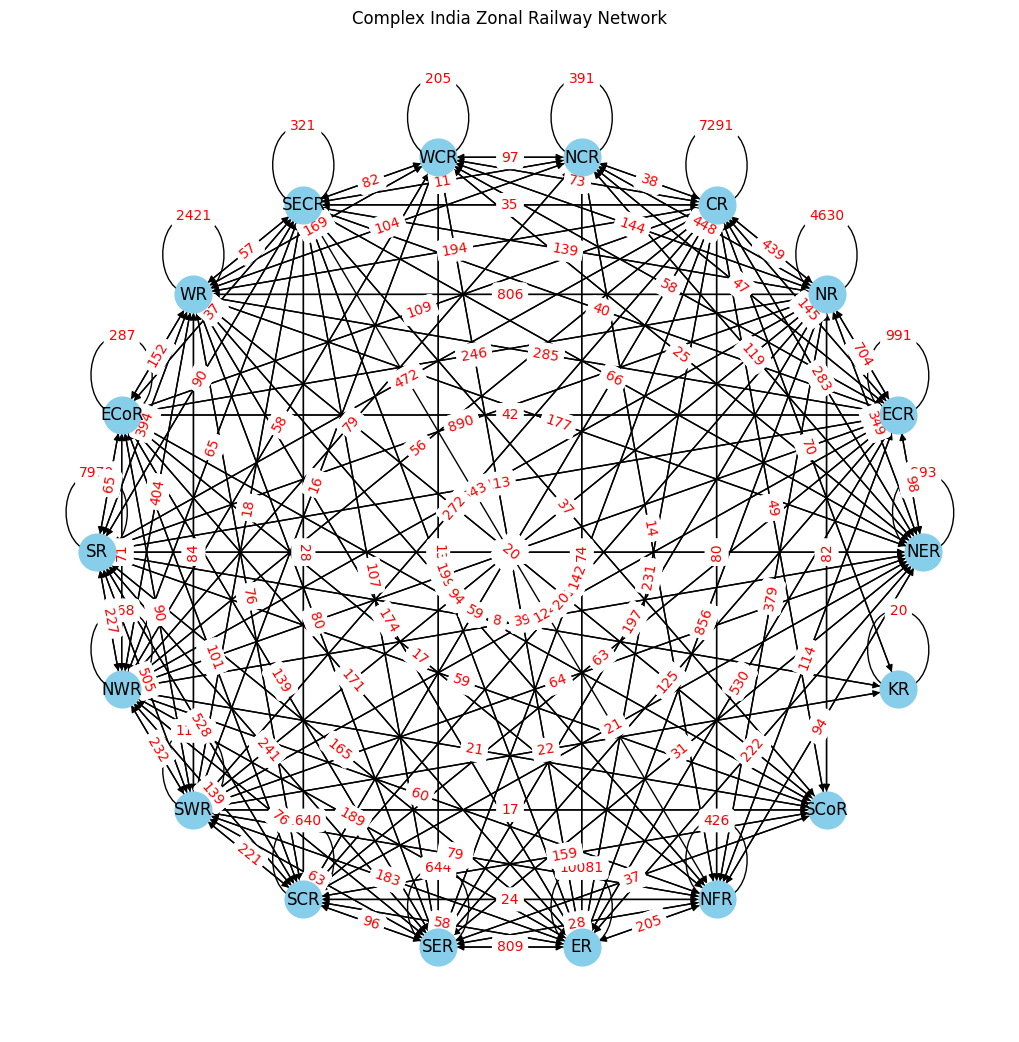

In [35]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for index, row in df2.iterrows():
    source_zone = row['Source Zone']
    destination_zone = row['Destination Zone']
    # Add edge between source and destination zones
    if G.has_edge(source_zone, destination_zone):
        G[source_zone][destination_zone]['weight'] += 1
    else:
        G.add_edge(source_zone, destination_zone, weight=1)

# Use circular layout for the nodes
pos = nx.circular_layout(G)

# Drawing the graph with circular layout
plt.figure(figsize=(10, 10))  # Set the size of the figure
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=12)

# Adding edge weight labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Complex India Zonal Railway Network")
plt.axis('off')
plt.show()



In [36]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/zone_weights/zone_weight.gpickle"

if os.path.exists(gpickle_path):
    try:
        with open(gpickle_path, 'rb') as f:
            train_graph = pickle.load(f)
        print("Graph loaded successfully!")
    except Exception as e:
        print(f"Failed to load the graph: {e}")
else:
    print("Gpickle file not found, generating a new graph.")
    train_graph = G
    try:
        with open(gpickle_path, 'wb') as f:
            pickle.dump(train_graph, f, pickle.HIGHEST_PROTOCOL)
        print("Graph written successfully!")
    except Exception as e:
        print(f"Failed to write the graph: {e}")

Gpickle file not found, generating a new graph.
Graph written successfully!


###NR

In [77]:
nr_df = pd.read_csv("/content/drive/MyDrive/ANU/project/dataset/filtered_NR.csv")
nr_df = nr_df.dropna()

In [78]:

gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/nr.gpickle"

if os.path.exists(gpickle_path):
    try:
        with open(gpickle_path, 'rb') as f:
            railway_network = pickle.load(f)
        print("Graph loaded successfully!")
    except Exception as e:
        print(f"Failed to load the graph: {e}")
else:
    print("Gpickle file not found, generating a new graph.")
    railway_network = generate_graph(nr_df)
    try:
        with open(gpickle_path, 'wb') as f:
            pickle.dump(railway_network, f, pickle.HIGHEST_PROTOCOL)
        print("Graph written successfully!")
    except Exception as e:
        print(f"Failed to write the graph: {e}")

Gpickle file not found, generating a new graph.
Graph written successfully!


###SR

In [80]:
sr_df = pd.read_csv("/content/drive/MyDrive/ANU/project/dataset/filtered_SR.csv")
sr_df = sr_df.dropna()

In [81]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/sr.gpickle"

if os.path.exists(gpickle_path):
    try:
        with open(gpickle_path, 'rb') as f:
            railway_network = pickle.load(f)
        print("Graph loaded successfully!")
    except Exception as e:
        print(f"Failed to load the graph: {e}")
else:
    print("Gpickle file not found, generating a new graph.")
    railway_network = generate_graph(sr_df)
    try:
        with open(gpickle_path, 'wb') as f:
            pickle.dump(railway_network, f, pickle.HIGHEST_PROTOCOL)
        print("Graph written successfully!")
    except Exception as e:
        print(f"Failed to write the graph: {e}")

Gpickle file not found, generating a new graph.
Graph written successfully!


###ER

In [83]:
er_df = pd.read_csv("/content/drive/MyDrive/ANU/project/dataset/filtered_ER.csv")
er_df = er_df.dropna()

In [84]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/er.gpickle"

if os.path.exists(gpickle_path):
    try:
        with open(gpickle_path, 'rb') as f:
            railway_network = pickle.load(f)
        print("Graph loaded successfully!")
    except Exception as e:
        print(f"Failed to load the graph: {e}")
else:
    print("Gpickle file not found, generating a new graph.")
    railway_network = generate_graph(er_df)
    try:
        with open(gpickle_path, 'wb') as f:
            pickle.dump(railway_network, f, pickle.HIGHEST_PROTOCOL)
        print("Graph written successfully!")
    except Exception as e:
        print(f"Failed to write the graph: {e}")

Gpickle file not found, generating a new graph.
Graph written successfully!


###WR

In [86]:
wr_df = pd.read_csv("/content/drive/MyDrive/ANU/project/dataset/filtered_WR.csv")
wr_df = wr_df.dropna()

In [87]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/wr.gpickle"

if os.path.exists(gpickle_path):
    try:
        with open(gpickle_path, 'rb') as f:
            railway_network = pickle.load(f)
        print("Graph loaded successfully!")
    except Exception as e:
        print(f"Failed to load the graph: {e}")
else:
    print("Gpickle file not found, generating a new graph.")
    railway_network = generate_graph(wr_df)
    try:
        with open(gpickle_path, 'wb') as f:
            pickle.dump(railway_network, f, pickle.HIGHEST_PROTOCOL)
        print("Graph written successfully!")
    except Exception as e:
        print(f"Failed to write the graph: {e}")

Gpickle file not found, generating a new graph.
Graph written successfully!


###CR

In [88]:
cr_df = pd.read_csv("/content/drive/MyDrive/ANU/project/dataset/filtered_CR.csv")
cr_df = cr_df.dropna()

In [89]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/cr.gpickle"

if os.path.exists(gpickle_path):
    try:
        with open(gpickle_path, 'rb') as f:
            railway_network = pickle.load(f)
        print("Graph loaded successfully!")
    except Exception as e:
        print(f"Failed to load the graph: {e}")
else:
    print("Gpickle file not found, generating a new graph.")
    railway_network = generate_graph(cr_df)
    try:
        with open(gpickle_path, 'wb') as f:
            pickle.dump(railway_network, f, pickle.HIGHEST_PROTOCOL)
        print("Graph written successfully!")
    except Exception as e:
        print(f"Failed to write the graph: {e}")

Gpickle file not found, generating a new graph.
Graph written successfully!


#LOADING ALL GRAPHS

In [9]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/old_train_count_weighted.gpickle"

In [10]:
with open(gpickle_path, 'rb') as f:
            train_graph = pickle.load(f)

print(train_graph)

DiGraph with 1594 nodes and 68347 edges


In [11]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/zone_weights/zone_weight.gpickle"

In [12]:
with open(gpickle_path, 'rb') as f:
            zone_network = pickle.load(f)

print(zone_network)

DiGraph with 18 nodes and 260 edges


In [13]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/er.gpickle"

In [14]:
with open(gpickle_path, 'rb') as f:
            er_network = pickle.load(f)

print(er_network)

DiGraph with 153 nodes and 1591 edges


In [15]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/nr.gpickle"

In [16]:
with open(gpickle_path, 'rb') as f:
            nr_network = pickle.load(f)

print(nr_network)

DiGraph with 309 nodes and 4530 edges


In [17]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/sr.gpickle"

In [18]:
with open(gpickle_path, 'rb') as f:
            sr_network = pickle.load(f)

print(sr_network)

DiGraph with 134 nodes and 1932 edges


In [19]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/wr.gpickle"

In [20]:
with open(gpickle_path, 'rb') as f:
            wr_network = pickle.load(f)

print(wr_network)

DiGraph with 144 nodes and 1526 edges


In [21]:
gpickle_path = "/content/drive/MyDrive/ANU/project/dataset/weights/train_weights/cr.gpickle"

In [22]:
with open(gpickle_path, 'rb') as f:
            cr_network = pickle.load(f)

print(cr_network)

DiGraph with 99 nodes and 921 edges


#ANALYSIS OF NETWORKS

##Station Graph Visualisation- v messy

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.circular_layout(train_graph)
plt.figure(figsize=(12, 12))
nx.draw(train_graph, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='k', linewidths=1, font_size=12)

edge_labels = nx.get_edge_attributes(train_graph, 'weight')
nx.draw_networkx_edge_labels(train_graph, pos, edge_labels=edge_labels)

plt.title('Railway Network Graph')
plt.show()


##Zone graph comparisons

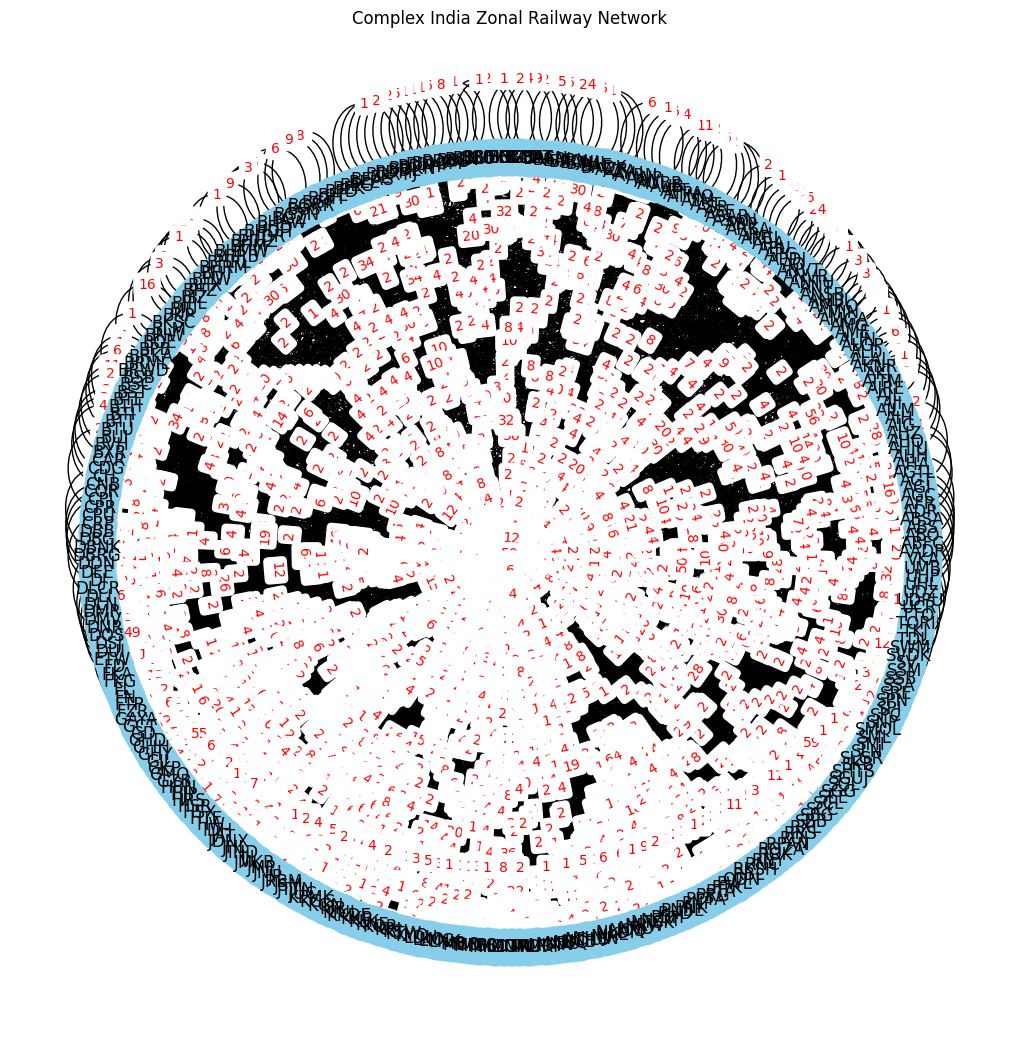

In [79]:
pos = nx.circular_layout(railway_network)

plt.figure(figsize=(10, 10))  # Set the size of the figure
nx.draw(railway_network, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=12)

edge_labels = nx.get_edge_attributes(railway_network, 'weight')
nx.draw_networkx_edge_labels(railway_network, pos, edge_labels=edge_labels, font_color='red')

plt.title("Complex India Zonal Railway Network")
plt.axis('off')
plt.show()

#CENTRALITY MEASURES AND INFERENCES

In [ ]:
import operator
def compute_centrality(graph, description, df):
    centrality = {}
    if description == "Degree":
        centrality = nx.degree_centrality(graph)
    elif description == "Betweenness":
        centrality = nx.betweenness_centrality(graph)
    elif description == "Closeness":
        centrality = nx.closeness_centrality(graph)
    elif description == "Eigen Vector":
        centrality = nx.eigenvector_centrality_numpy(graph)

    sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    return [(df[df['Station Code'] == code]['Station Name'].values[0], value) for code, value in sorted_centrality]


COMPUTE DEGREE CENTRALITY

In [74]:
centrality = {}
centrality = nx.degree_centrality(train_graph)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((df.loc[df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Degree Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Degree Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 HOWRAH JN. 		 0.30211146575006137
	 VIJAYWADA JN 		 0.2704394794991407
	 KANPUR CENTR 		 0.263810459121041
	 VARANASI JN. 		 0.25767247728946724
	 GHAZIABAD JN 		 0.25202553400441935
	 KALYAN JN 		 0.24797446599558065
	 ITARSI 		 0.24441443653326786
	 LUCKNOW JN. 		 0.243677878713479
	 AHMEDABAD 		 0.23852197397495703
	 MATHURA JN. 		 0.2363123005155905


COMPUTE BETWEENNESS CENTRALITY

In [73]:
centrality = {}
centrality = nx.betweenness_centrality(train_graph)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((df.loc[df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Betweenness Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top stations in the Indian Railway System acc to the Betweenness Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 HOWRAH JN. 		 0.03406351792928565
	 SEALDAH 		 0.021795409939440936
	 KANPUR CENTR 		 0.020930718809083173
	 VIJAYWADA JN 		 0.015177400281457002
	 AHMEDABAD 		 0.014301664879802252
	 YESVANTPUR J 		 0.014256569821548529
	 VADODARA JN. 		 0.012967968029171826
	 VARANASI JN. 		 0.012623744668081235
	 KOLKATA 		 0.011898350401287686
	 PILIBHIT JN. 		 0.01184539309233258


COMPUTE CLOSENESS CENTRALITY

In [75]:
centrality = {}
centrality = nx.closeness_centrality(train_graph)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((df.loc[df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Closeness Centrality:\n\n \tSTATION NAME\t\t CLOSENESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Closeness Centrality:

 	STATION NAME		 CLOSENESS CENTRALITY
	 HOWRAH JN. 		 0.5124082033874587
	 AHMEDABAD 		 0.5107660799308908
	 VADODARA JN. 		 0.5063522924820026
	 KANPUR CENTR 		 0.5062879529276847
	 VARANASI JN. 		 0.5052287059583946
	 NEW DELHI 		 0.5051966767517281
	 KALYAN JN 		 0.5036640360941574
	 MUGHAL SARAI 		 0.5035049206471066
	 VIJAYWADA JN 		 0.5021406666088064
	 ITARSI 		 0.4998101090743702


OTHER APPROACH:

In [93]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Degree Centrality
degree_centrality = nx.degree_centrality(zone_network)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(zone_network, weight='weight')

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(zone_network, distance='weight')


print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Closeness Centrality:", closeness_centrality)


Degree Centrality: {'NER': 1.7647058823529411, 'ECR': 1.8823529411764706, 'NR': 2.0, 'CR': 2.1176470588235294, 'NCR': 1.2941176470588236, 'WCR': 1.4117647058823528, 'SECR': 1.9411764705882353, 'WR': 2.0, 'ECoR': 1.6470588235294117, 'SR': 1.7647058823529411, 'NWR': 2.0, 'SWR': 2.0, 'SCR': 1.7647058823529411, 'SER': 1.8823529411764706, 'ER': 1.8823529411764706, 'NFR': 1.588235294117647, 'SCoR': 1.1764705882352942, 'KR': 0.47058823529411764}
Betweenness Centrality: {'NER': 0.02022058823529412, 'ECR': 0.025735294117647058, 'NR': 0.0, 'CR': 0.0, 'NCR': 0.03676470588235294, 'WCR': 0.1801470588235294, 'SECR': 0.2738970588235294, 'WR': 0.0, 'ECoR': 0.003676470588235294, 'SR': 0.003676470588235294, 'NWR': 0.0625, 'SWR': 0.42830882352941174, 'SCR': 0.03676470588235294, 'SER': 0.014705882352941176, 'ER': 0.0, 'NFR': 0.13786764705882354, 'SCoR': 0.29044117647058826, 'KR': 0.11029411764705882}
Closeness Centrality: {'NER': 0.01768990634755463, 'ECR': 0.017223910840932118, 'NR': 0.00819672131147541,

##ER

In [121]:
centrality = {}
centrality = nx.degree_centrality(er_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((er_df.loc[er_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Degree Centrality:\n\n \tSTATION NAME\t\t DEGREE CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Degree Centrality:

 	STATION NAME		 DEGREE CENTRALITY
	 SEALDAH 		 0.5657894736842105
	 DUM DUM JN. 		 0.4671052631578947
	 BANDEL JN. 		 0.41447368421052627
	 NAIHATI JN. 		 0.4013157894736842
	 BARRACKPORE 		 0.3881578947368421
	 HOWRAH JN. 		 0.3881578947368421
	 BARDDHAMAN J 		 0.381578947368421
	 KOLKATA 		 0.34868421052631576
	 MAJERHAT 		 0.2894736842105263
	 RAMPUR HAT 		 0.2763157894736842


In [122]:
centrality = {}
centrality = nx.betweenness_centrality(er_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((er_df.loc[er_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Betweenness Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Betweenness Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 DUM DUM JN. 		 0.04190382174917948
	 BARDDHAMAN J 		 0.03128145325611221
	 BARRACKPORE 		 0.024796965321577977
	 NAIHATI JN. 		 0.021885805544399096
	 HOWRAH JN. 		 0.016902428767576947
	 BANDEL JN. 		 0.014323062909753093
	 SEALDAH 		 0.014072047672057017
	 KOLKATA 		 0.01395498777540154
	 BALLYGUNGE J 		 0.012048168071754413
	 RAMPUR HAT 		 0.01037757021834514


In [123]:
centrality = {}
centrality = nx.closeness_centrality(er_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((er_df.loc[er_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Closeness Centrality:\n\n \tSTATION NAME\t\t CLOSENESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Closeness Centrality:

 	STATION NAME		 CLOSENESS CENTRALITY
	 SEALDAH 		 0.5645803698435278
	 SAINTHIA JN. 		 0.464614468269439
	 NAIHATI JN. 		 0.4586855740387238
	 ANDAL JN. 		 0.4493243243243243
	 RAMPUR HAT 		 0.41189931350114417
	 TINPAHAR JN. 		 0.38605091159270727
	 SONARPUR JN. 		 0.37232225300092336
	 THAKURNAGAR 		 0.3710204269414796
	 PUNDOOAH 		 0.3675886143931257
	 NALHATI JN. 		 0.3664210526315789


##SR

In [127]:
centrality = {}
centrality = nx.degree_centrality(sr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((sr_df.loc[sr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Degree Centrality:\n\n \tSTATION NAME\t\t DEGREE CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Degree Centrality:

 	STATION NAME		 DEGREE CENTRALITY
	 TIRUCHIRAPPA 		 0.5338345864661653
	 CHENNAI EGMO 		 0.5263157894736842
	 VILLUPURAM J 		 0.518796992481203
	 CHENGALPATTU 		 0.49624060150375937
	 TAMBARAM 		 0.48872180451127817
	 ERODE JN. 		 0.48120300751879697
	 COIMBATORE 		 0.47368421052631576
	 PALAKKAD JN 		 0.47368421052631576
	 TIRUNELVELI 		 0.47368421052631576
	 ALWAYE 		 0.46616541353383456


In [128]:
centrality = {}
centrality = nx.betweenness_centrality(sr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((sr_df.loc[sr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Betweenness Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Betweenness Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 CHENNAI BEAC 		 0.02684149636776453
	 AVADI 		 0.025691554979031837
	 CHENNAI EGMO 		 0.024755585962890844
	 KATPADI JN 		 0.01921347852322024
	 ERODE JN. 		 0.017015868806919066
	 DINDIGUL JN 		 0.01543300548494907
	 CHENGALPATTU 		 0.015328414058750784
	 MELMARUVATHU 		 0.013424995739254951
	 BUDALUR 		 0.013176911753687213
	 TAMBARAM 		 0.01267347624820974


In [129]:
centrality = {}
centrality = nx.closeness_centrality(sr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((sr_df.loc[sr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Closeness Centrality:\n\n \tSTATION NAME\t\t CLOSENESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Closeness Centrality:

 	STATION NAME		 CLOSENESS CENTRALITY
	 VILLUPURAM J 		 0.583342972816657
	 VIRUDUNAGAR 		 0.5639464514945901
	 TIRUCHIRAPPA 		 0.5615763546798029
	 TRIVANDRUM C 		 0.5495973436128392
	 VRIDHA CHALA 		 0.5364438493494009
	 TIRUNELVELI 		 0.5146616541353384
	 TAMBARAM 		 0.5069320700595419
	 TRICHUR 		 0.5046939382354191
	 THANJAVUR JN 		 0.4646098003629764
	 TIRUVALLUR 		 0.4461839530332681


##WR

In [131]:
centrality = {}
centrality = nx.degree_centrality(wr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((wr_df.loc[wr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Degree Centrality:\n\n \tSTATION NAME\t\t DEGREE CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Degree Centrality:

 	STATION NAME		 DEGREE CENTRALITY
	 VADODARA JN. 		 0.5524475524475524
	 AHMEDABAD 		 0.5174825174825175
	 ANAND JN. 		 0.5034965034965035
	 BORIVLI 		 0.4965034965034965
	 SURAT 		 0.4965034965034965
	 NADIAD JN. 		 0.46153846153846156
	 BHARUCH JN. 		 0.4195804195804196
	 VALSAD 		 0.4195804195804196
	 VIRAMGAM JN 		 0.4125874125874126
	 VAPI 		 0.40559440559440557


In [132]:
centrality = {}
centrality = nx.betweenness_centrality(wr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((wr_df.loc[wr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Betweenness Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Betweenness Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 VADODARA JN. 		 0.03166776543154262
	 BORIVLI 		 0.014215305135512848
	 ANAND JN. 		 0.012522249740239362
	 NADIAD JN. 		 0.0122988887207663
	 JUNAGADH JN 		 0.01014164881297019
	 SURAT 		 0.009701282735587088
	 DAHOD 		 0.006602102904919807
	 MAHESANA JN 		 0.004885079709023371
	 INDORE BG 		 0.004736695229652975
	 DHOLA JN 		 0.004077009130184674


In [133]:
centrality = {}
centrality = nx.closeness_centrality(wr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((wr_df.loc[wr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Closeness Centrality:\n\n \tSTATION NAME\t\t CLOSENESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Closeness Centrality:

 	STATION NAME		 CLOSENESS CENTRALITY
	 SURAT 		 0.5052447552447553
	 VIRAMGAM JN 		 0.46609390609390605
	 WANKANER 		 0.46323031806902776
	 VAPI 		 0.4575024975024975
	 SURENDRANAGA 		 0.424923391215526
	 VIRAR 		 0.41541958041958044
	 UDHNA JN. 		 0.39683548774457866
	 NADIAD JN. 		 0.39215153778260575
	 UMBERGAON RO 		 0.3874266437080507
	 VERAVAL 		 0.3759453216466791


##NR

In [134]:
centrality = {}
centrality = nx.degree_centrality(nr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((nr_df.loc[nr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Degree Centrality:\n\n \tSTATION NAME\t\t DEGREE CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Degree Centrality:

 	STATION NAME		 DEGREE CENTRALITY
	 DELHI JN. 		 0.5032467532467533
	 GHAZIABAD JN 		 0.4090909090909091
	 NEW JALPAIGU 		 0.35389610389610393
	 AMBALA CANTT 		 0.35064935064935066
	 NEW BONGAIGA 		 0.34090909090909094
	 SAHARANPUR J 		 0.33766233766233766
	 GUWAHATI 		 0.33441558441558444
	 LUCKNOW JN. 		 0.32792207792207795
	 NEW DELHI 		 0.3246753246753247
	 LUDHIANA JN. 		 0.3181818181818182


In [135]:
centrality = {}
centrality = nx.betweenness_centrality(nr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((nr_df.loc[nr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Betweenness Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Betweenness Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 DELHI JN. 		 0.04654884372036762
	 BAREILLY JN. 		 0.01736052087543535
	 KANPUR CENTR 		 0.015820095748417955
	 NEW DELHI 		 0.015819755194731486
	 GHAZIABAD JN 		 0.014903365514891602
	 LUDHIANA JN. 		 0.01430405296426968
	 GUWAHATI 		 0.013591212361073296
	 LUCKNOW JN. 		 0.013065039846589107
	 MUGHAL SARAI 		 0.011877442815156743
	 MORADABAD JN 		 0.00791292996882694


In [136]:
centrality = {}
centrality = nx.closeness_centrality(nr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((nr_df.loc[nr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Closeness Centrality:\n\n \tSTATION NAME\t\t CLOSENESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Closeness Centrality:

 	STATION NAME		 CLOSENESS CENTRALITY
	 AMBALA CANTT 		 0.5255890641796682
	 SAHARANPUR J 		 0.47073474470734744
	 SHAHJAHANPUR 		 0.44276787514038074
	 TUNDLA JN 		 0.43359418359418356
	 UDHAMPUR 		 0.4197657482704212
	 SIWAN JN. 		 0.4156101834673263
	 RANGIYA JN. 		 0.4152467532467532
	 SHRI MATA VA 		 0.4150281748047111
	 SHIKOHABAD J 		 0.4132788559754852
	 SIMALUGURI J 		 0.41283220091167117


##CR

In [137]:
centrality = {}
centrality = nx.degree_centrality(cr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((cr_df.loc[cr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Degree Centrality:\n\n \tSTATION NAME\t\t DEGREE CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Degree Centrality:

 	STATION NAME		 DEGREE CENTRALITY
	 CST-MUMBAI 		 0.6224489795918366
	 THANE 		 0.6020408163265306
	 KALYAN JN 		 0.5918367346938775
	 DADAR 		 0.5714285714285714
	 PUNE JN. 		 0.5102040816326531
	 NAGPUR JN.(C 		 0.44897959183673464
	 BHUSAVAL JN. 		 0.4387755102040816
	 MANMAD JN. 		 0.4387755102040816
	 AKOLA JN. 		 0.3877551020408163
	 BADNERA JN. 		 0.3877551020408163


In [138]:
centrality = {}
centrality = nx.betweenness_centrality(cr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((cr_df.loc[cr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Betweenness Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Betweenness Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 CST-MUMBAI 		 0.040166493749900035
	 BHUSAVAL JN. 		 0.033089060293256534
	 KALYAN JN 		 0.028373102075917134
	 DADAR 		 0.021413640085167603
	 NAGPUR JN.(C 		 0.017545910312077015
	 PANVEL 		 0.014335324213141314
	 PUNE JN. 		 0.01371717156211909
	 THANE 		 0.012630062328388543
	 DAUND JN. 		 0.01244778783259134
	 BADNERA JN. 		 0.00992312118968383


In [139]:
centrality = {}
centrality = nx.closeness_centrality(cr_network)
centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
stations = []
for item in centrality:
    station_code = item[0]
    stations.append((cr_df.loc[cr_df['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

print("Top Stations in the Indian Railway System acc to the Closeness Centrality:\n\n \tSTATION NAME\t\t CLOSENESS CENTRALITY")
for item in stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Closeness Centrality:

 	STATION NAME		 CLOSENESS CENTRALITY
	 THANE 		 0.6436224489795918
	 WARDHA JN. 		 0.5375537970290157
	 PUNE JN. 		 0.517384731670446
	 PANDHARPUR 		 0.44842155612244894
	 NAGPUR JN.(C 		 0.44471963542698634
	 PARBHANI JN. 		 0.4166666666666667
	 TALEGAON 		 0.416233159930639
	 SHIVAJINAGAR 		 0.4138775510204082
	 KALYAN JN 		 0.41357265797885423
	 VIDYAVIHAR 		 0.4115646258503401


#CORRELATION BETWEEN IN AND OUT DEGREE

In [86]:
import networkx as nx
import numpy as np

in_degrees = [d for n, d in train_graph.in_degree()]
out_degrees = [d for n, d in train_graph.out_degree()]

# Calculate average in-degree and out-degree
avg_in_degree = np.mean(in_degrees)
avg_out_degree = np.mean(out_degrees)

print(f"Average In-Degree: {avg_in_degree:.2f}")
print(f"Average Out-Degree: {avg_out_degree:.2f}")

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
print(f"Correlation Coefficient between in-degrees and out-degrees: {correlation_coef:.4f}")


Average In-Degree: 110.79
Average Out-Degree: 110.79
Correlation Coefficient between in-degrees and out-degrees: 0.9635


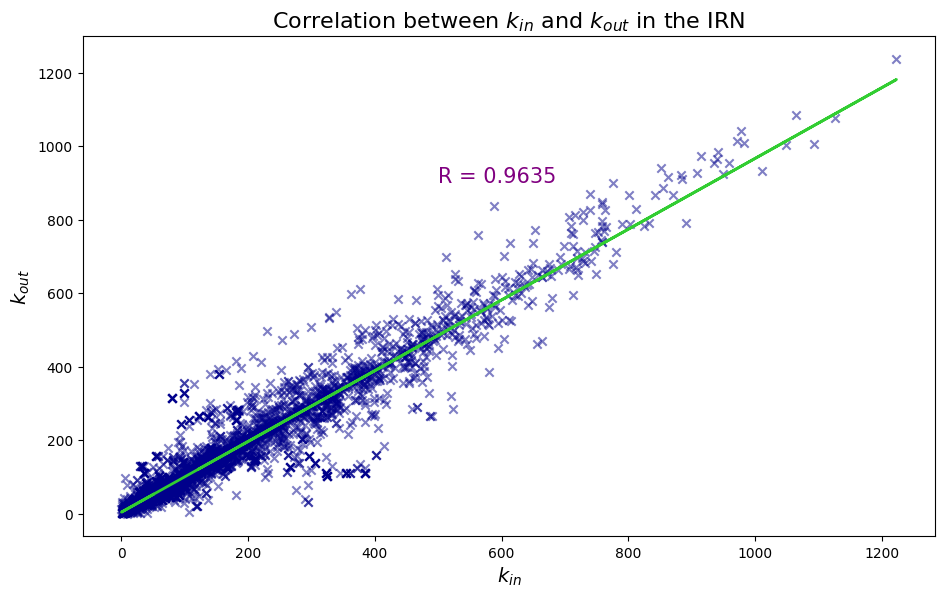

In [184]:
in_degrees = [d for n, d in train_graph.in_degree()]
out_degrees = [d for n, d in train_graph.out_degree()]

plt.figure(figsize=(11, 6.5))
plt.scatter(in_degrees, out_degrees, marker='x', color='darkblue', alpha=0.5)
plt.xlabel("$k_{in}$", fontsize=14)
plt.ylabel("$k_{out}$", fontsize=14)

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
plt.text(500, 900, f"R = {correlation_coef:.4f}", fontsize=15, color='purple')

m, b = np.polyfit(in_degrees, out_degrees, 1)
plt.plot(in_degrees, m*np.array(in_degrees) + b, color='limegreen', linewidth=2)

plt.title("Correlation between $k_{in}$ and $k_{out}$ in the IRN", fontsize=16)
plt.show()


##NR

In [87]:
in_degrees = [d for n, d in nr_network.in_degree()]
out_degrees = [d for n, d in nr_network.out_degree()]

avg_in_degree = np.mean(in_degrees)
avg_out_degree = np.mean(out_degrees)

print(f"Average In-Degree: {avg_in_degree:.2f}")
print(f"Average Out-Degree: {avg_out_degree:.2f}")

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
print(f"Correlation Coefficient between in-degrees and out-degrees: {correlation_coef:.4f}")


Average In-Degree: 14.66
Average Out-Degree: 14.66
Correlation Coefficient between in-degrees and out-degrees: 0.2287


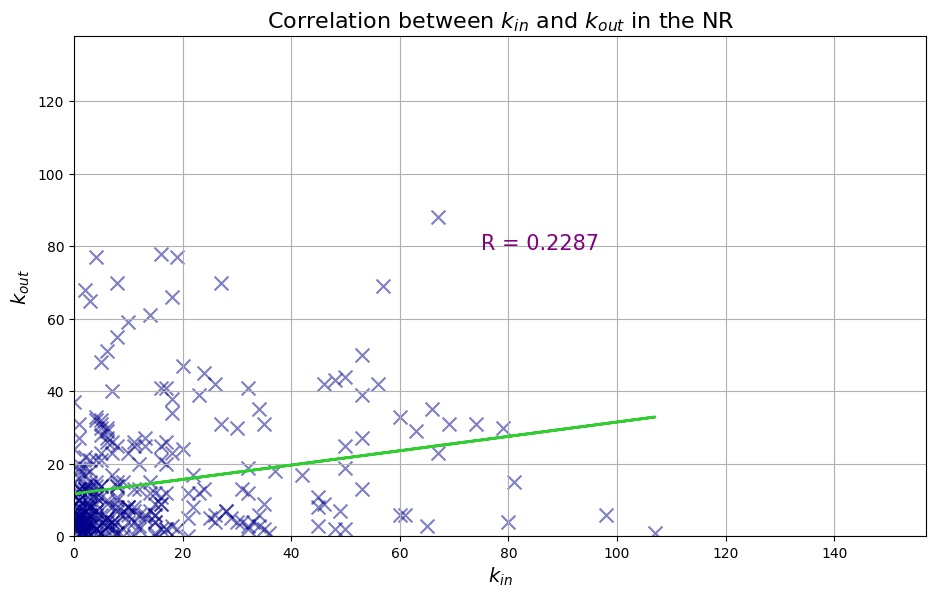

In [81]:
in_degrees = [d for n, d in train_graph.in_degree()]
out_degrees = [d for n, d in train_graph.out_degree()]

plt.figure(figsize=(11, 6.5))
plt.scatter(in_degrees, out_degrees, marker='x', color='darkblue', alpha=0.5)
plt.xlabel("$k_{in}$", fontsize=14)
plt.ylabel("$k_{out}$", fontsize=14)

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
plt.text(500, 900, f"R = {correlation_coef:.4f}", fontsize=15, color='purple')

m, b = np.polyfit(in_degrees, out_degrees, 1)
plt.plot(in_degrees, m*np.array(in_degrees) + b, color='limegreen', linewidth=2)

plt.title("Correlation between $k_{in}$ and $k_{out}$ in the NR", fontsize=16)
plt.show()


##SR

In [88]:
in_degrees = [d for n, d in sr_network.in_degree()]
out_degrees = [d for n, d in sr_network.out_degree()]

avg_in_degree = np.mean(in_degrees)
avg_out_degree = np.mean(out_degrees)

print(f"Average In-Degree: {avg_in_degree:.2f}")
print(f"Average Out-Degree: {avg_out_degree:.2f}")

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
print(f"Correlation Coefficient between in-degrees and out-degrees: {correlation_coef:.4f}")


Average In-Degree: 14.42
Average Out-Degree: 14.42
Correlation Coefficient between in-degrees and out-degrees: -0.0288


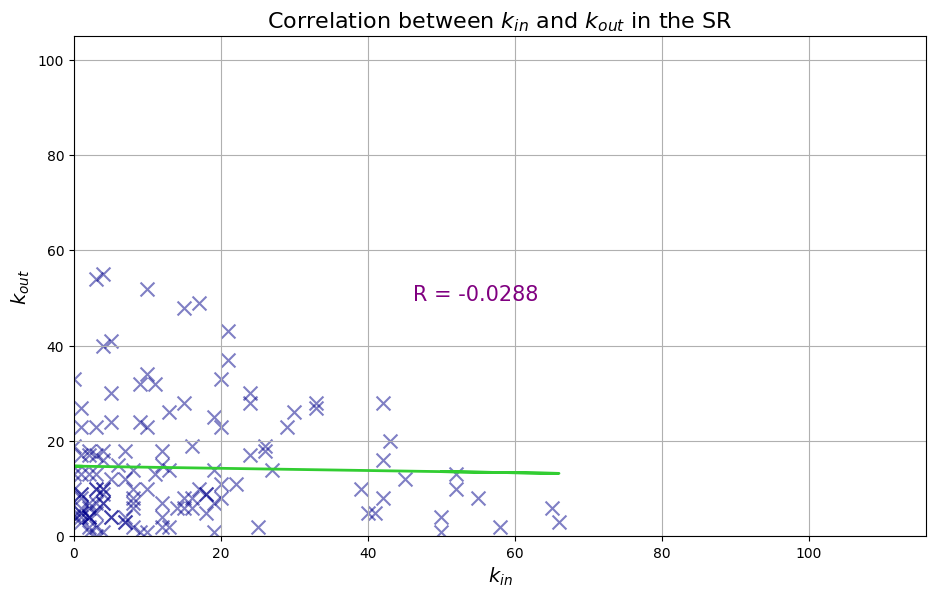

In [82]:
in_degrees = [d for n, d in train_graph.in_degree()]
out_degrees = [d for n, d in train_graph.out_degree()]

plt.figure(figsize=(11, 6.5))
plt.scatter(in_degrees, out_degrees, marker='x', color='darkblue', alpha=0.5)
plt.xlabel("$k_{in}$", fontsize=14)
plt.ylabel("$k_{out}$", fontsize=14)

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
plt.text(500, 900, f"R = {correlation_coef:.4f}", fontsize=15, color='purple')

m, b = np.polyfit(in_degrees, out_degrees, 1)
plt.plot(in_degrees, m*np.array(in_degrees) + b, color='limegreen', linewidth=2)

plt.title("Correlation between $k_{in}$ and $k_{out}$ in the SR", fontsize=16)
plt.show()


##WR

In [89]:
in_degrees = [d for n, d in wr_network.in_degree()]
out_degrees = [d for n, d in wr_network.out_degree()]

avg_in_degree = np.mean(in_degrees)
avg_out_degree = np.mean(out_degrees)

print(f"Average In-Degree: {avg_in_degree:.2f}")
print(f"Average Out-Degree: {avg_out_degree:.2f}")

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
print(f"Correlation Coefficient between in-degrees and out-degrees: {correlation_coef:.4f}")


Average In-Degree: 10.60
Average Out-Degree: 10.60
Correlation Coefficient between in-degrees and out-degrees: 0.1889


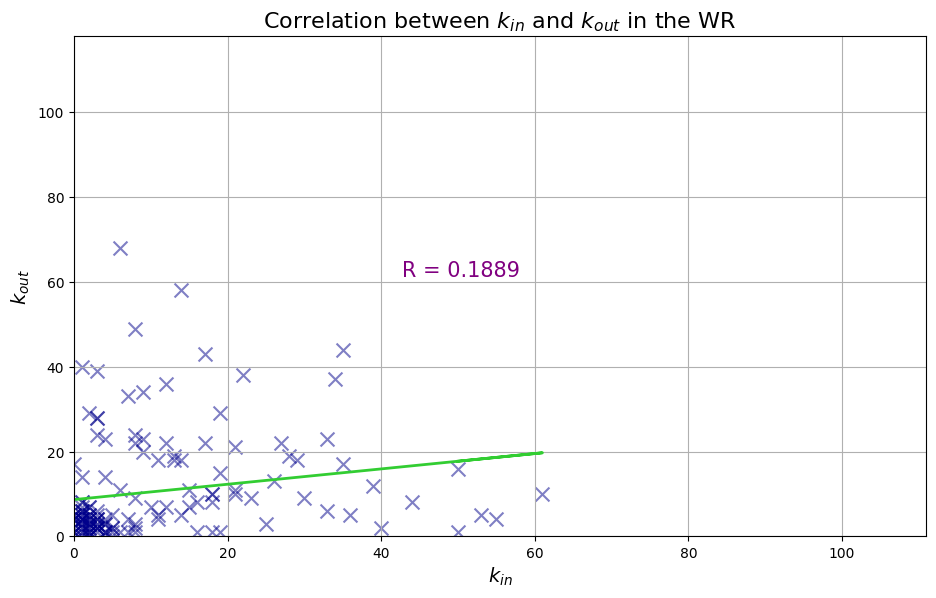

In [83]:
in_degrees = [d for n, d in train_graph.in_degree()]
out_degrees = [d for n, d in train_graph.out_degree()]

plt.figure(figsize=(11, 6.5))
plt.scatter(in_degrees, out_degrees, marker='x', color='darkblue', alpha=0.5)
plt.xlabel("$k_{in}$", fontsize=14)
plt.ylabel("$k_{out}$", fontsize=14)

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
plt.text(500, 900, f"R = {correlation_coef:.4f}", fontsize=15, color='purple')

m, b = np.polyfit(in_degrees, out_degrees, 1)
plt.plot(in_degrees, m*np.array(in_degrees) + b, color='limegreen', linewidth=2)

plt.title("Correlation between $k_{in}$ and $k_{out}$ in the WR", fontsize=16)
plt.show()


##ER

In [90]:
in_degrees = [d for n, d in er_network.in_degree()]
out_degrees = [d for n, d in er_network.out_degree()]

avg_in_degree = np.mean(in_degrees)
avg_out_degree = np.mean(out_degrees)

print(f"Average In-Degree: {avg_in_degree:.2f}")
print(f"Average Out-Degree: {avg_out_degree:.2f}")

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
print(f"Correlation Coefficient between in-degrees and out-degrees: {correlation_coef:.4f}")


Average In-Degree: 10.40
Average Out-Degree: 10.40
Correlation Coefficient between in-degrees and out-degrees: 0.0139


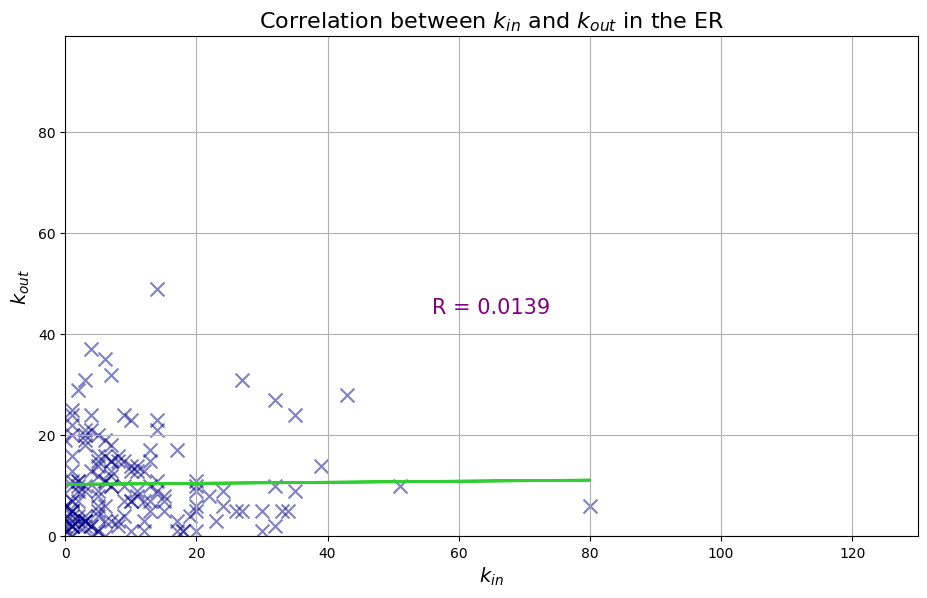

In [84]:
in_degrees = [d for n, d in train_graph.in_degree()]
out_degrees = [d for n, d in train_graph.out_degree()]

plt.figure(figsize=(11, 6.5))
plt.scatter(in_degrees, out_degrees, marker='x', color='darkblue', alpha=0.5)
plt.xlabel("$k_{in}$", fontsize=14)
plt.ylabel("$k_{out}$", fontsize=14)

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
plt.text(500, 900, f"R = {correlation_coef:.4f}", fontsize=15, color='purple')

m, b = np.polyfit(in_degrees, out_degrees, 1)
plt.plot(in_degrees, m*np.array(in_degrees) + b, color='limegreen', linewidth=2)

plt.title("Correlation between $k_{in}$ and $k_{out}$ in the ER", fontsize=16)
plt.show()


##CR

In [91]:
in_degrees = [d for n, d in cr_network.in_degree()]
out_degrees = [d for n, d in cr_network.out_degree()]

avg_in_degree = np.mean(in_degrees)
avg_out_degree = np.mean(out_degrees)

print(f"Average In-Degree: {avg_in_degree:.2f}")
print(f"Average Out-Degree: {avg_out_degree:.2f}")

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
print(f"Correlation Coefficient between in-degrees and out-degrees: {correlation_coef:.4f}")


Average In-Degree: 9.30
Average Out-Degree: 9.30
Correlation Coefficient between in-degrees and out-degrees: 0.1309


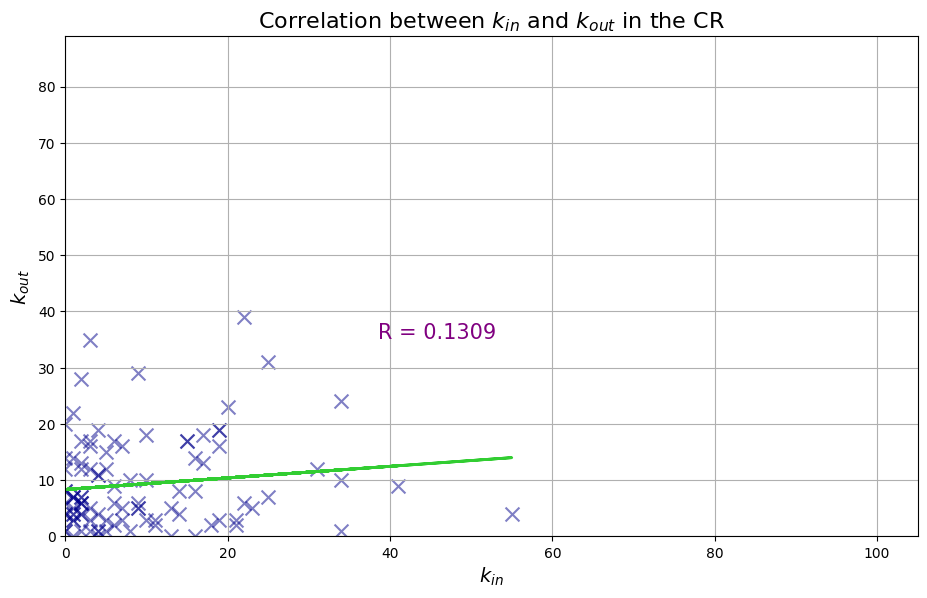

In [85]:
in_degrees = [d for n, d in train_graph.in_degree()]
out_degrees = [d for n, d in train_graph.out_degree()]

plt.figure(figsize=(11, 6.5))
plt.scatter(in_degrees, out_degrees, marker='x', color='darkblue', alpha=0.5)
plt.xlabel("$k_{in}$", fontsize=14)
plt.ylabel("$k_{out}$", fontsize=14)

correlation_coef = np.corrcoef(in_degrees, out_degrees)[0, 1]
plt.text(500, 900, f"R = {correlation_coef:.4f}", fontsize=15, color='purple')

m, b = np.polyfit(in_degrees, out_degrees, 1)
plt.plot(in_degrees, m*np.array(in_degrees) + b, color='limegreen', linewidth=2)

plt.title("Correlation between $k_{in}$ and $k_{out}$ in the CR", fontsize=16)
plt.show()


#DEGREE DISTRIBUTION

In [68]:
def calculate_degree_distribution(network):

    degree_sequence = sorted([degree for node, degree in network.degree()])
    degree_count = collections.Counter(degree_sequence)

    degrees, frequencies = zip(*degree_count.items())
    plt.figure(figsize=(11, 6))
    plt.scatter(degrees, frequencies, color='darkcyan', marker='o')
    plt.xlabel("Degree (k)", fontsize=12)
    plt.ylabel("Frequency (P(k))", fontsize=12)
    plt.title("Degree Distribution of the CR", fontsize=14)
    plt.grid(True)
    plt.show()



In [ ]:
calculate_degree_distribution(train_graph_undirected)


##NR

In [29]:
nr_network_undirected = nr_network.to_undirected()

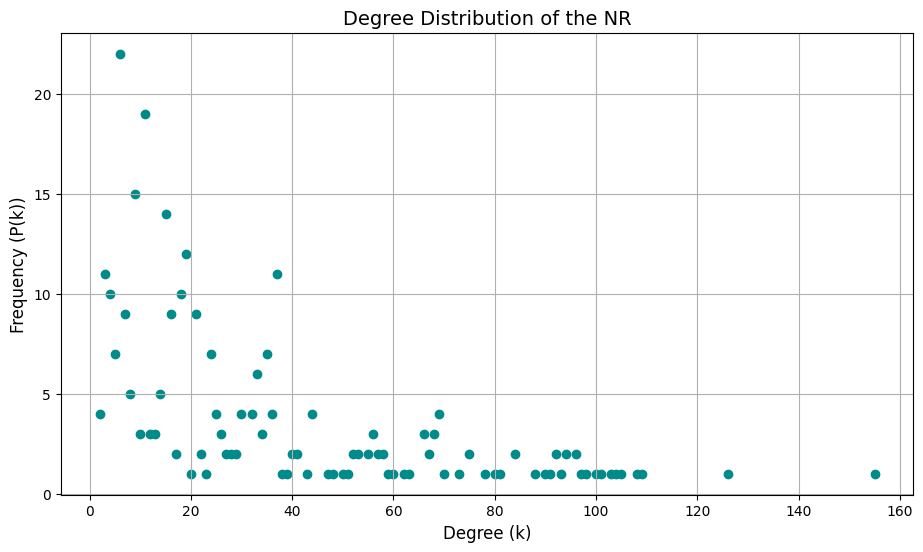

In [61]:
calculate_degree_distribution(nr_network_undirected)


##SR

In [30]:
sr_network_undirected = sr_network.to_undirected()

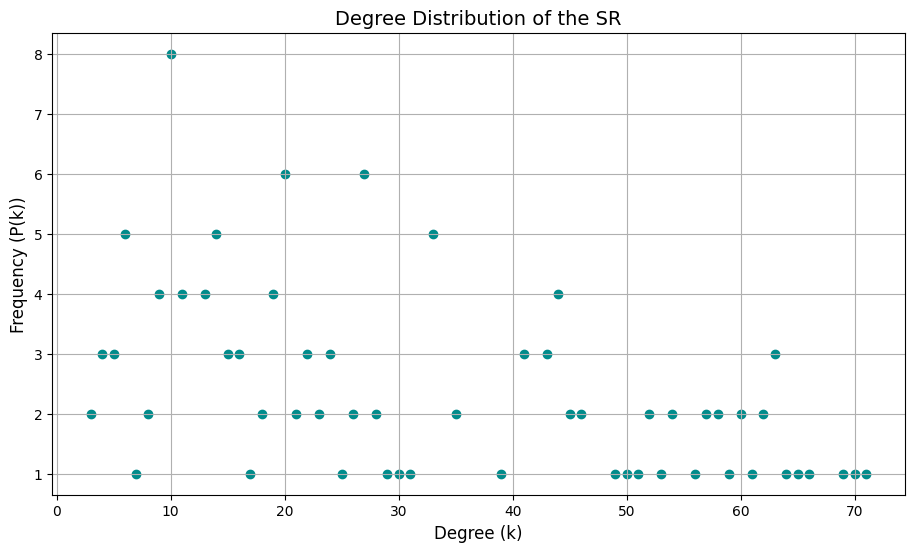

In [63]:
calculate_degree_distribution(sr_network_undirected)


##ER

In [31]:
er_network_undirected = er_network.to_undirected()

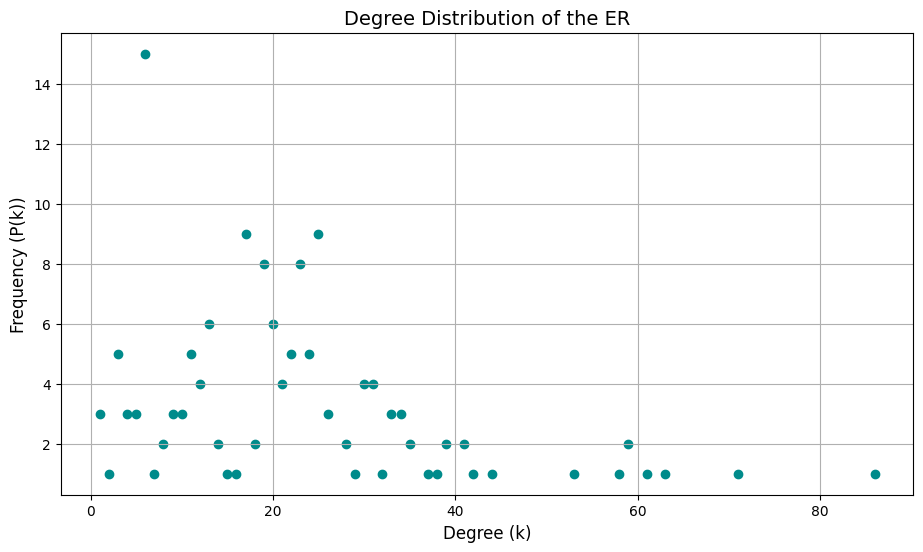

In [65]:
calculate_degree_distribution(er_network_undirected)


##WR

In [32]:
wr_network_undirected = wr_network.to_undirected()

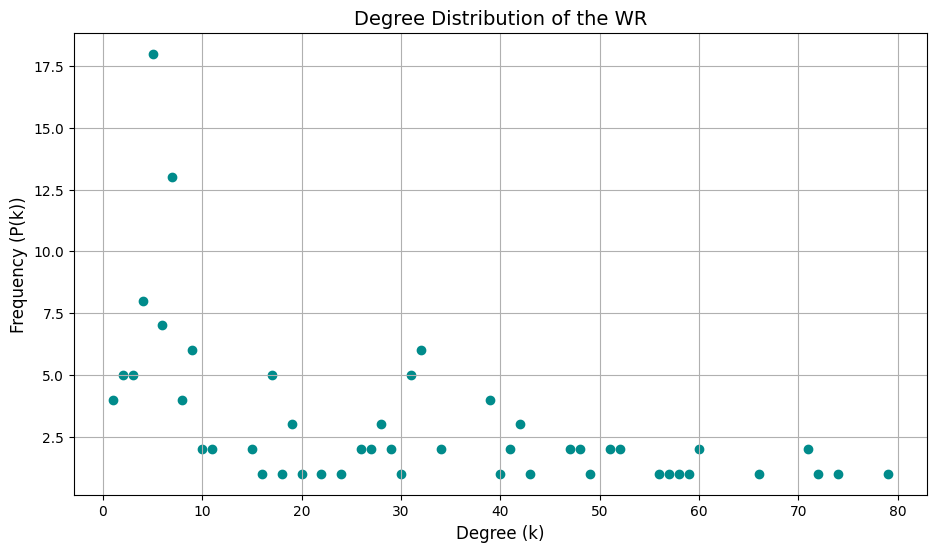

In [67]:
calculate_degree_distribution(wr_network_undirected)


##CR

In [33]:
cr_network_undirected = cr_network.to_undirected()

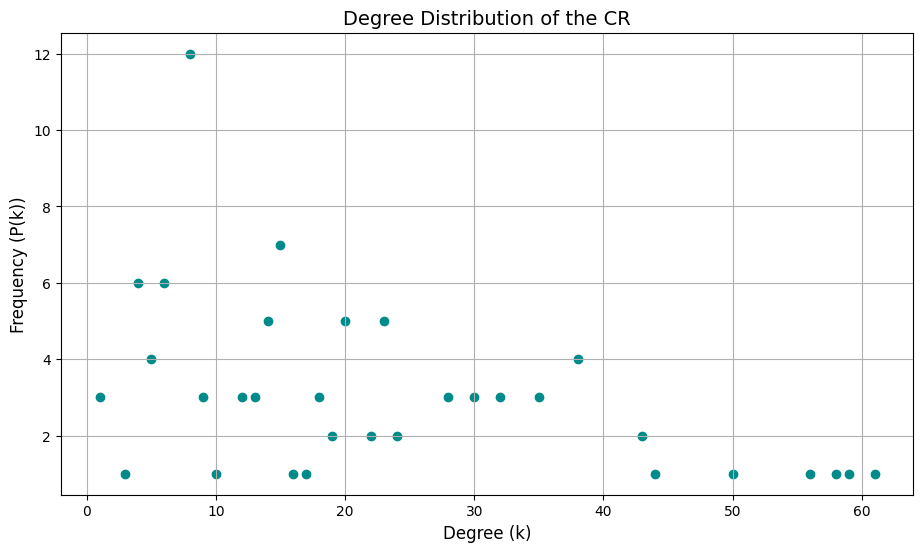

In [69]:
calculate_degree_distribution(cr_network_undirected)


#CUMULATIVE STRENGTH DISTRIBUTION

In [79]:
def calculate_cumulative_degree_distribution(network):

    degree_sequence = sorted([degree for node, degree in network.degree()])
    degree_count = collections.Counter(degree_sequence)

    degrees, counts = zip(*degree_count.items())
    cumulative_counts = np.cumsum(counts[::-1])[::-1]

    plt.figure(figsize=(11, 6))
    plt.scatter(degrees, cumulative_counts, color='blue', alpha=0.7)  # Enhanced point visibility
    plt.xlabel("Degree (k)", fontsize=12)
    plt.ylabel("Cumulative Frequency (P(k))", fontsize=12)
    plt.title("Cumulative Degree Distribution in ER", fontsize=14)

    m, b = np.polyfit(np.array(degrees), np.array(cumulative_counts), 1)
    plt.plot(np.array(degrees), m * np.array(degrees) + b, color='magenta', linestyle='--', linewidth=2)

    plt.grid(True)
    plt.show()

calculate_cumulative_degree_distribution(train_graph_undirected)


##NR

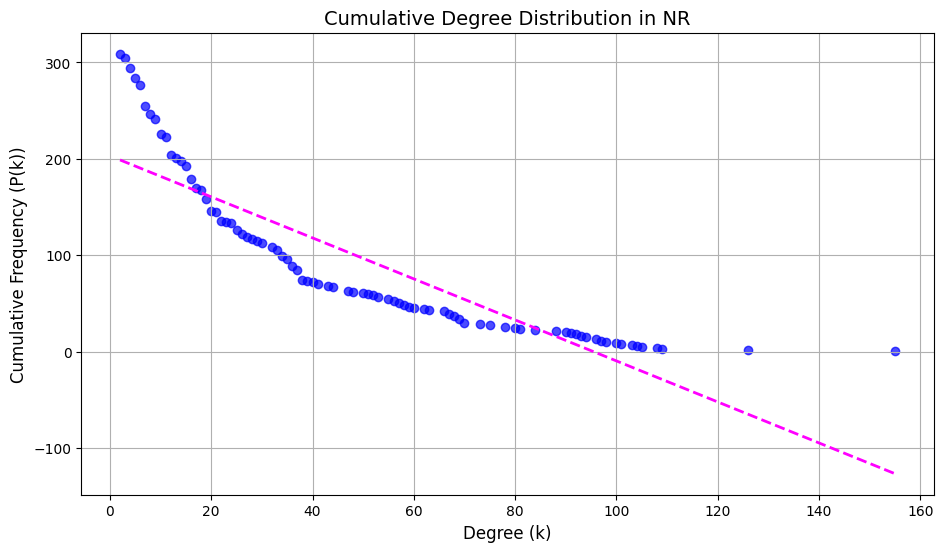

In [72]:
calculate_cumulative_degree_distribution(nr_network_undirected)


##SR

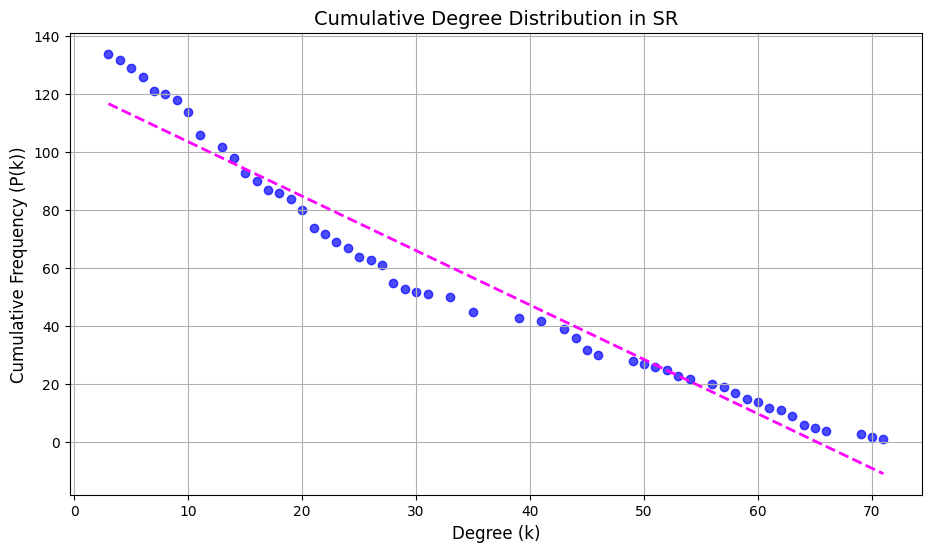

In [74]:
calculate_cumulative_degree_distribution(sr_network_undirected)


##CR

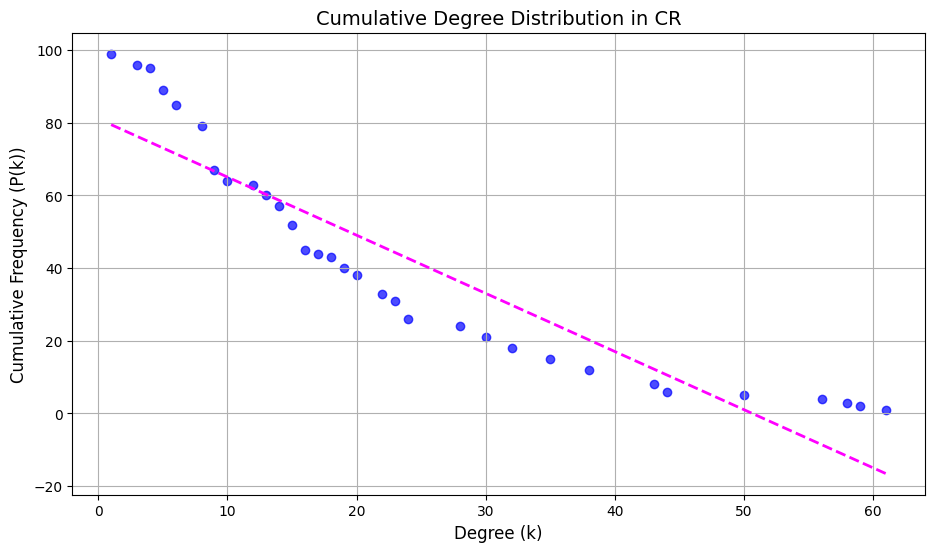

In [76]:
calculate_cumulative_degree_distribution(cr_network_undirected)


##WR

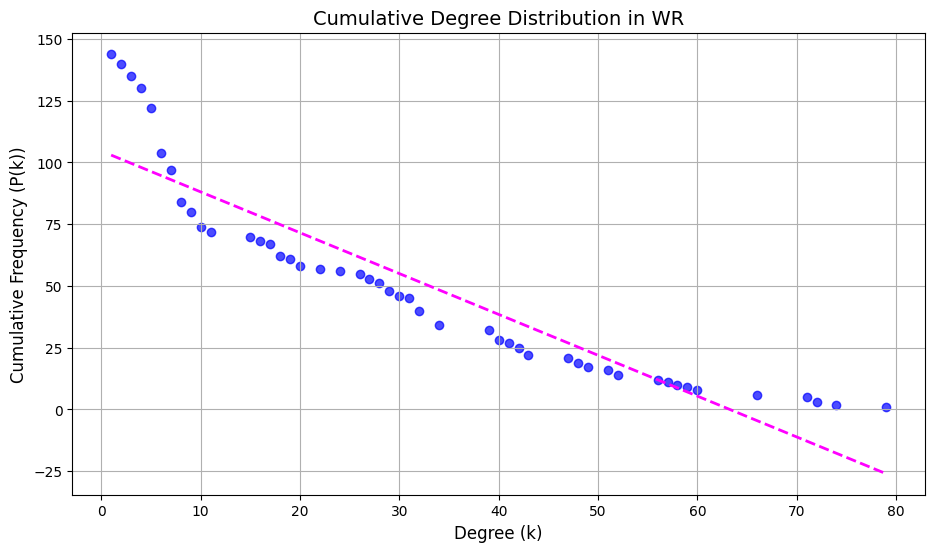

In [78]:
calculate_cumulative_degree_distribution(wr_network_undirected)


##ER

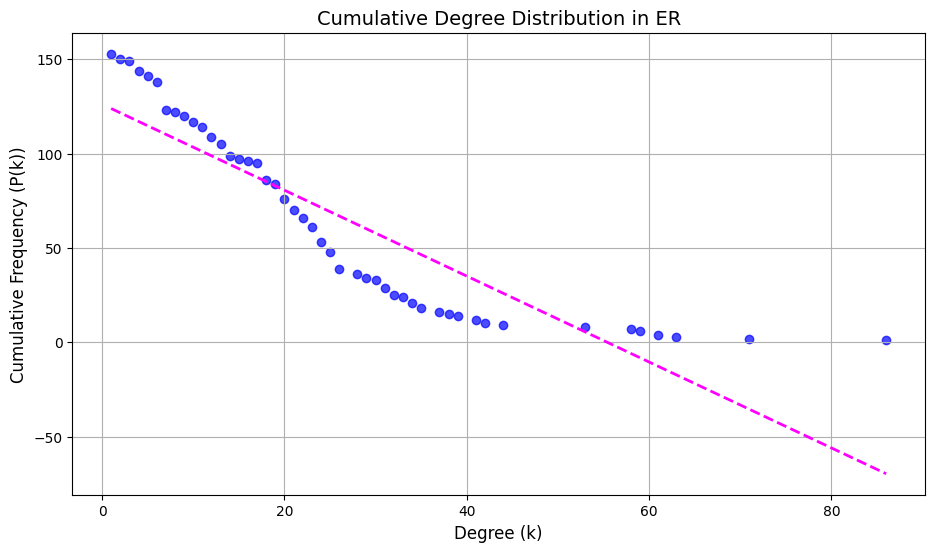

In [80]:
calculate_cumulative_degree_distribution(er_network_undirected)


#CLUSTERING COEFFICIENT

In [39]:
Clustering_Coefficient = nx.average_clustering(nr_network_undirected)
print("The Clustering Coefficent of NORTH ZONE: ", Clustering_Coefficient)

Clustering_Coefficient = nx.average_clustering(sr_network_undirected)
print("The Clustering Coefficent of SOUTH ZONE: ", Clustering_Coefficient)

Clustering_Coefficient = nx.average_clustering(wr_network_undirected)
print("The Clustering Coefficent of WEST ZONE: ", Clustering_Coefficient)

Clustering_Coefficient = nx.average_clustering(er_network_undirected)
print("The Clustering Coefficent of EAST ZONE: ", Clustering_Coefficient)

Clustering_Coefficient = nx.average_clustering(cr_network_undirected)
print("The Clustering Coefficent of CENTRAL ZONE: ", Clustering_Coefficient)

Clustering_Coefficient = nx.average_clustering(train_graph_undirected)
print("The Clustering Coefficent of THE IRN: ", Clustering_Coefficient)

The Clustering Coefficent of NORTH ZONE:  0.8080361387170414
The Clustering Coefficent of SOUTH ZONE:  0.7656283271479928
The Clustering Coefficent of WEST ZONE:  0.7883414755738596
The Clustering Coefficent of EAST ZONE:  0.7610601609879115
The Clustering Coefficent of CENTRAL ZONE:  0.7735868142758112


AttributeError: 'function' object has no attribute 'is_directed'

In [23]:
def calculate_clustering_coefficient(network):

    node_clustering_values = nx.clustering(network)
    node_degree_values = dict(network.degree())
    unique_degrees = set(node_degree_values.values())
    degree_clustering = {
        degree: sum(node_clustering_values[node] for node in node_degree_values if node_degree_values[node] == degree) / sum(1 for node in node_degree_values if node_degree_values[node] == degree)
        for degree in unique_degrees
    }

    return degree_clustering

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_clustering_correlation(degree_clustering):

    degree_values = list(degree_clustering.keys())
    clustering_values = list(degree_clustering.values())
    plt.figure(figsize=(11, 6))
    plt.scatter(degree_values, clustering_values, color='blue', alpha=0.6)

    plt.xlabel("Degree (k)", fontsize=12)
    plt.ylabel("Clustering Coefficient (C(k))", fontsize=12)
    plt.title("Degree-Clustering Coefficient Correlation in CR", fontsize=14)

    # Linear regression line
    m, b = np.polyfit(np.array(degree_values), np.array(clustering_values), 1)
    plt.plot(np.array(degree_values), m * np.array(degree_values) + b, color='green', linestyle='--', linewidth=2)

    # Add slope text
    plt.text(max(degree_values) * 0.7, max(clustering_values) * 0.7, f"Slope = {round(m, 4)}", fontsize=15, color='darkgreen')
    plt.grid(True)
    plt.show()



In [38]:
train_graph_undirected = train_graph.to_undirected

##NR

In [41]:
degree_clustering = calculate_clustering_coefficient(nr_network_undirected)
print(degree_clustering)


{2: 1.0, 3: 0.8181818181818182, 4: 1.0, 5: 0.9714285714285714, 6: 0.9848484848484849, 7: 0.9666666666666666, 8: 1.0, 9: 0.956084656084656, 10: 0.8928571428571428, 11: 0.938569909622541, 12: 1.0, 13: 0.9696969696969697, 14: 0.8384615384615385, 15: 0.923600209314495, 16: 0.9377289377289377, 17: 0.8857142857142857, 18: 0.890359477124183, 19: 0.7913943355119827, 20: 0.7157894736842105, 21: 0.7453634085213033, 22: 0.7554112554112553, 23: 0.7523809523809524, 24: 0.7428678981474013, 25: 0.6709486166007905, 26: 0.6364734299516909, 27: 0.5348433048433049, 28: 0.8492063492063492, 29: 0.5797720797720798, 30: 0.8736772486772486, 32: 0.746551724137931, 33: 0.8236559139784946, 34: 0.6062870162727848, 35: 0.8605283022299829, 36: 0.7440836940836941, 37: 0.905729564553094, 38: 0.5349206349206349, 39: 0.43543543543543545, 40: 0.8769559032716927, 41: 0.8987854251012146, 43: 0.3804878048780488, 44: 0.687862950058072, 47: 0.8252525252525252, 48: 0.6434782608695652, 50: 0.5868794326241135, 51: 0.85544217687

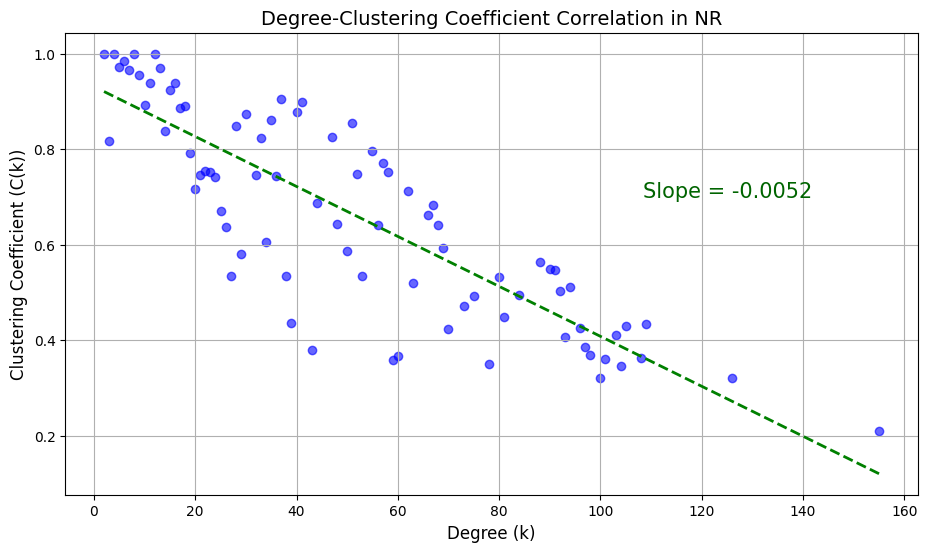

In [42]:
plot_clustering_correlation(degree_clustering)


##SR

In [44]:
degree_clustering = calculate_clustering_coefficient(sr_network_undirected)
print(degree_clustering)


{3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 0.8, 8: 1.0, 9: 1.0, 10: 0.9080357142857144, 11: 0.7448232323232323, 13: 0.9227272727272728, 14: 0.883916083916084, 15: 0.875946275946276, 16: 0.9263736263736263, 17: 0.9333333333333333, 18: 0.7666666666666666, 19: 0.7629536463708291, 20: 0.7882868937048504, 21: 0.7777777777777778, 22: 0.7782486519328624, 23: 0.6666666666666667, 24: 0.7316017316017316, 25: 0.8466666666666667, 26: 0.7463768115942029, 27: 0.7732051282051282, 28: 0.7288359788359788, 29: 0.6773399014778325, 30: 0.8571428571428571, 31: 0.7684729064039408, 33: 0.6385068426197458, 35: 0.7424242424242424, 39: 0.8588588588588588, 41: 0.7246963562753037, 43: 0.7585365853658536, 44: 0.6666666666666666, 45: 0.53156146179402, 46: 0.6300211416490487, 49: 0.6290471785383904, 50: 0.6578014184397163, 51: 0.6386054421768708, 52: 0.5710204081632653, 53: 0.6619607843137255, 54: 0.6297134238310709, 56: 0.6114605171208944, 57: 0.6084175084175084, 58: 0.5795454545454546, 59: 0.449874686716792, 60: 0.539927

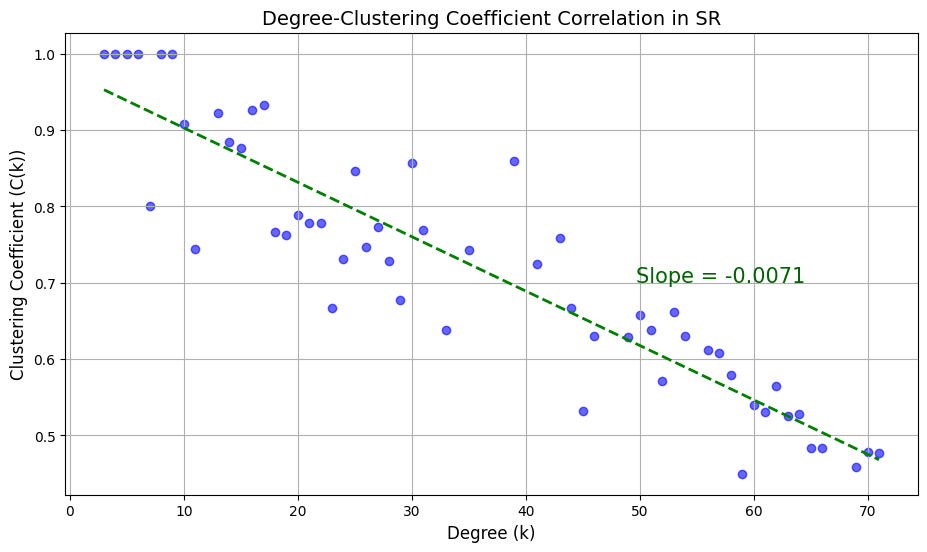

In [45]:
plot_clustering_correlation(degree_clustering)


##WR

In [48]:
degree_clustering = calculate_clustering_coefficient(wr_network_undirected)
print(degree_clustering)


{1: 0.0, 2: 0.8, 3: 0.26666666666666666, 4: 0.9583333333333333, 5: 1.0, 6: 0.8904761904761905, 7: 0.9926739926739927, 8: 0.6333333333333333, 9: 0.8174603174603176, 10: 0.8214285714285714, 11: 1.0, 15: 0.819047619047619, 16: 0.6483516483516484, 17: 0.9109663865546219, 18: 0.8823529411764706, 19: 0.8259803921568628, 20: 0.7315789473684211, 22: 0.6263157894736842, 24: 0.6406926406926406, 26: 0.6963489409141583, 27: 0.84, 28: 0.5784615384615385, 29: 0.9074074074074074, 30: 0.9788359788359788, 31: 0.9354679802955663, 32: 0.7800766283524904, 34: 0.8215725806451613, 39: 0.8836336336336336, 40: 0.8691322901849218, 41: 0.8110661268556005, 42: 0.7987179487179489, 43: 0.6731707317073171, 47: 0.7191919191919192, 48: 0.7265700483091787, 49: 0.6780758556891767, 51: 0.6441326530612246, 52: 0.6616326530612244, 56: 0.6023759608665269, 57: 0.5555555555555556, 58: 0.6162337662337662, 59: 0.5895989974937343, 60: 0.5859044162129461, 66: 0.5084325396825397, 71: 0.46398124467178176, 72: 0.4331262939958592, 7

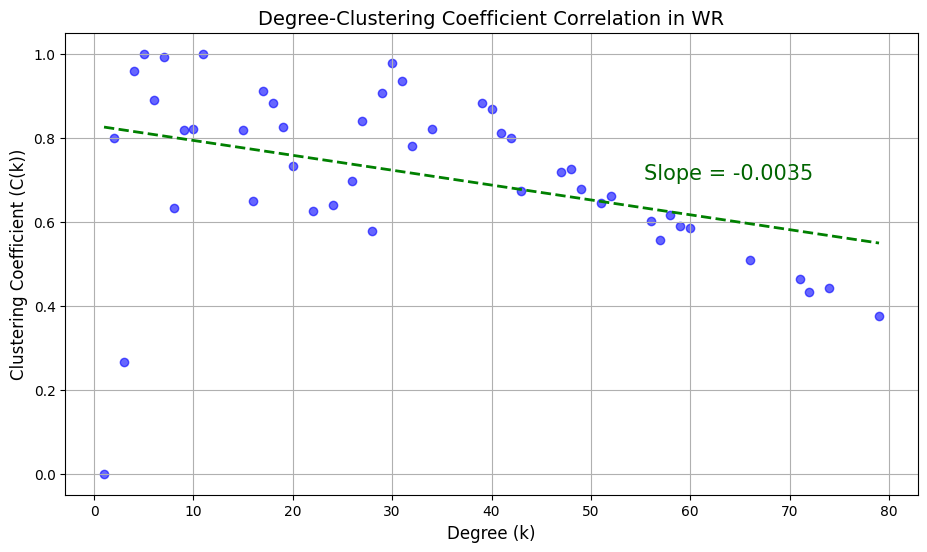

In [49]:
plot_clustering_correlation(degree_clustering)


##ER

In [54]:
# Assuming Railway_Network_Undirected is defined and is a NetworkX graph
degree_clustering = calculate_clustering_coefficient(er_network_undirected)
print(degree_clustering)


{1: 0.0, 2: 1.0, 3: 0.4, 4: 0.8888888888888888, 5: 0.7333333333333334, 6: 0.9444444444444444, 7: 1.0, 8: 0.7, 9: 1.0, 10: 0.9761904761904763, 11: 1.0, 12: 0.9555555555555555, 13: 0.9342268842268843, 14: 0.9505494505494505, 15: 0.6410256410256411, 16: 0.9120879120879121, 17: 0.9227513227513229, 18: 0.5541666666666667, 19: 0.8990690574475404, 20: 0.874395138172228, 21: 0.5789473684210527, 22: 0.9305263157894738, 23: 0.8791666666666665, 24: 0.8095238095238095, 25: 0.8344312692138778, 26: 0.7065217391304347, 28: 0.7292307692307692, 29: 0.603988603988604, 30: 0.6613756613756614, 31: 0.624384236453202, 32: 0.5448275862068965, 33: 0.5921146953405018, 34: 0.538978494623656, 35: 0.5397727272727273, 37: 0.44537815126050423, 38: 0.573015873015873, 39: 0.503003003003003, 41: 0.5236167341430499, 42: 0.45256410256410257, 44: 0.4645760743321719, 53: 0.36705882352941177, 58: 0.33181818181818185, 59: 0.3085839598997494, 61: 0.2875511396843951, 63: 0.36120218579234975, 71: 0.27408354646206307, 86: 0.216

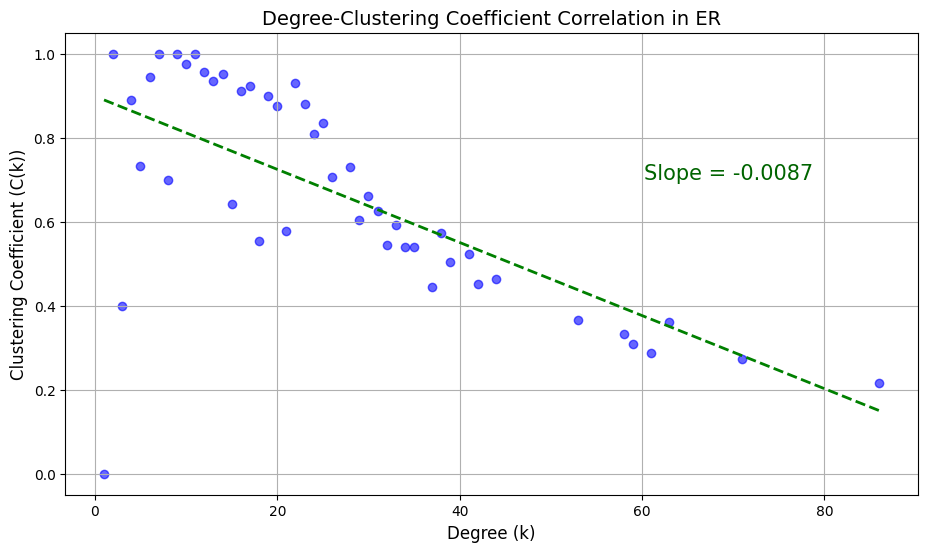

In [55]:
# Assuming Degree_Clustering is a dictionary obtained from the function calculate_clustering_coefficient
plot_clustering_correlation(degree_clustering)


##CR

In [57]:
degree_clustering = calculate_clustering_coefficient(cr_network_undirected)
print(degree_clustering)


{1: 0.0, 3: 1.0, 4: 0.9722222222222223, 5: 0.8999999999999999, 6: 0.9722222222222222, 8: 1.0, 9: 1.0, 10: 0.9333333333333333, 12: 0.8787878787878788, 13: 0.8578088578088577, 14: 0.9912087912087912, 15: 0.9670329670329672, 16: 0.5833333333333334, 17: 0.6617647058823529, 18: 0.7111111111111111, 19: 0.8602941176470589, 20: 0.7673065015479877, 22: 0.4789473684210526, 23: 0.72, 24: 0.7597402597402598, 28: 0.6572405372405373, 30: 0.5970017636684304, 32: 0.5992337164750957, 35: 0.5397727272727274, 38: 0.5242063492063492, 43: 0.4420731707317073, 44: 0.4262485481997677, 50: 0.3829787234042553, 56: 0.39622641509433965, 58: 0.38181818181818183, 59: 0.35714285714285715, 61: 0.33196960841613093}


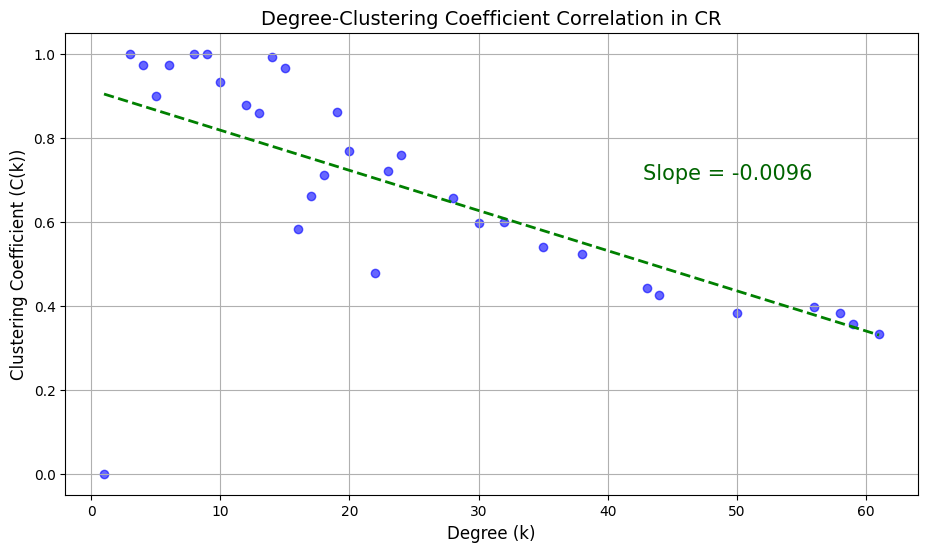

In [58]:
plot_clustering_correlation(degree_clustering)


#PATH LENGTH ANALYSIS

In [211]:
def analyze_path_length(network):
    shortest_path_lengths = list(nx.shortest_path_length(network))
    path_lengths = []

    for node_path_lengths in shortest_path_lengths:
        source_station = node_path_lengths[0]
        destination_stations = node_path_lengths[1]

        for station, length in destination_stations.items():
            path_lengths.append(length)

    # Calculate the average path length if there are any paths
    if path_lengths:
        average_path_length = sum(path_lengths) / len(path_lengths)
    else:
        average_path_length = 0  # Default to zero if no paths

    return path_lengths, average_path_length

path_lengths, average_path_length = analyze_path_length(train_graph_undirected)

print("Average Path Length:", average_path_length)


Average Path Length: 2.884106063708021


##NR

In [212]:
path_lengths, average_path_length = analyze_path_length(nr_network_undirected)

print("Average Path Length:", average_path_length)


Average Path Length: 2.4012505273633993


##SR

In [213]:
path_lengths, average_path_length = analyze_path_length(sr_network_undirected)

print("Average Path Length:", average_path_length)


Average Path Length: 2.1236355535754066


##WR

In [214]:
path_lengths, average_path_length = analyze_path_length(wr_network_undirected)

print("Average Path Length:", average_path_length)


Average Path Length: 2.4754147812971343


##ER

In [215]:
path_lengths, average_path_length = analyze_path_length(er_network_undirected)

print("Average Path Length:", average_path_length)


Average Path Length: 2.3587809690857267


##CR

In [216]:
path_lengths, average_path_length = analyze_path_length(cr_network_undirected)

print("Average Path Length:", average_path_length)


Average Path Length: 2.09937761452913
